## VAR model ver 1
using actual shortlisted variables

In [313]:
# Import libraries
import numpy as np 
import pandas as pd 
import seaborn as sns

import statsmodels.api as sm
from statsmodels.tsa.api import VAR
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.stats.stattools import durbin_watson
from statsmodels.tools.eval_measures import rmse, aic

import warnings
warnings.filterwarnings("ignore")

In [314]:
# Read csv
file_path = '../data/final/wo_na.csv'
df = pd.read_csv(file_path)

In [315]:
df.head()

,Unnamed: 0,Month_Dt,Month,Year,"HRC \n(FOB, $/t)",Domestic Scrap (DDP Jiangsu incl. VAT $/t),RM Cost \n($/t),HRC - RM \nSpread ($/t),CS Production (Mnt),Exports \n(Mnt),...,Monthly Export of semis & finished steel (Mt.),YTD Iron ore Imports (Mt.),YTD Iron ore Production (Mt.),Monthly Iron ore Production (Mt.),Fixed asset investment in real estate development in urban areas (y-o-y )Growth,Automobile Production (y-o-y),Civil Metal-Vessels/Steel Ships (y-o-y),Household Fridges (y-o-y),Air Conditioner (y-o-y),Manufacturing PMI for steel
0,8,2006-09-01,9,2006,472,252,211,261,36.0,5.0,...,5.14,247.20,405.80,56.50,24.3,24.0,6.0,34.2,3.9,51.7
1,9,2006-10-01,10,2006,477,260,185,292,38.0,5.0,...,5.19,297.69,462.30,56.50,24.1,25.1,11.4,31.8,6.7,55.9
2,10,2006-11-01,11,2006,470,262,182,288,38.0,6.0,...,6.11,297.69,521.50,59.20,24.0,26.1,8.3,28.9,7.2,54.9
3,11,2006-12-01,12,2006,470,270,188,282,39.0,6.0,...,6.05,326.30,588.20,66.70,21.8,27.0,13.1,15.8,16.1,50.1
4,12,2007-01-01,1,2007,470,273,197,273,38.0,5.0,...,4.95,133.55,252.28,69.01,24.3,45.0,8.6,15.8,16.1,55.4


In [316]:
df.columns.values

array(['Unnamed: 0', 'Month_Dt', 'Month', 'Year', 'HRC \n(FOB, $/t)',
       'Domestic Scrap (DDP Jiangsu incl. VAT $/t)', 'RM Cost \n($/t)',
       'HRC - RM \nSpread ($/t)', 'CS Production (Mnt)',
       'Exports \n(Mnt)', 'Imports \n(Mnt)', 'Export as % of Production',
       'Cummulative FAI growth (%)',
       'Monthly Imports of semis & finished steel (Mt.)',
       'Monthly Export of semis & finished steel (Mt.)',
       'YTD Iron ore Imports (Mt.)', 'YTD Iron ore Production (Mt.)',
       'Monthly Iron ore Production (Mt.)',
       'Fixed asset investment in real estate development in urban areas (y-o-y )Growth',
       'Automobile Production (y-o-y)',
       'Civil Metal-Vessels/Steel Ships (y-o-y)',
       'Household Fridges (y-o-y)', 'Air Conditioner (y-o-y)',
       'Manufacturing PMI for steel'], dtype=object)

### Section to be replaced by feature selection / granger causality test

For the sake of testing the VAR model, I will select a few stationary variables from the ADF test:

1. RM Cost ($/t)
2. HRC - RM Spread ($/t)
3. Export as % of Production

In [317]:
list_of_variables = ['Domestic Scrap (DDP Jiangsu incl. VAT $/t)', 'RM Cost \n($/t)', 'Monthly Export of semis & finished steel (Mt.)', 
                     'Fixed asset investment in real estate development in urban areas (y-o-y )Growth', 'Automobile Production (y-o-y)', 'Civil Metal-Vessels/Steel Ships (y-o-y)', 
                     'Household Fridges (y-o-y)', 'Air Conditioner (y-o-y)']
hrc = ['Month_Dt', 'HRC \n(FOB, $/t)']
final_cols = hrc + list_of_variables

df = df[final_cols]
df.head()

,Month_Dt,"HRC \n(FOB, $/t)",Domestic Scrap (DDP Jiangsu incl. VAT $/t),RM Cost \n($/t),Monthly Export of semis & finished steel (Mt.),Fixed asset investment in real estate development in urban areas (y-o-y )Growth,Automobile Production (y-o-y),Civil Metal-Vessels/Steel Ships (y-o-y),Household Fridges (y-o-y),Air Conditioner (y-o-y)
0,2006-09-01,472,252,211,5.14,24.3,24.0,6.0,34.2,3.9
1,2006-10-01,477,260,185,5.19,24.1,25.1,11.4,31.8,6.7
2,2006-11-01,470,262,182,6.11,24.0,26.1,8.3,28.9,7.2
3,2006-12-01,470,270,188,6.05,21.8,27.0,13.1,15.8,16.1
4,2007-01-01,470,273,197,4.95,24.3,45.0,8.6,15.8,16.1


In [318]:
# Set date column as the index
final_df = df.copy()
final_df = final_df.rename(columns={'Month_Dt':'Date'})
final_df.set_index('Date', inplace=True)

final_df.head()

,"HRC \n(FOB, $/t)",Domestic Scrap (DDP Jiangsu incl. VAT $/t),RM Cost \n($/t),Monthly Export of semis & finished steel (Mt.),Fixed asset investment in real estate development in urban areas (y-o-y )Growth,Automobile Production (y-o-y),Civil Metal-Vessels/Steel Ships (y-o-y),Household Fridges (y-o-y),Air Conditioner (y-o-y)
Date,,,,,,,,,
2006-09-01,472,252,211,5.14,24.3,24.0,6.0,34.2,3.9
2006-10-01,477,260,185,5.19,24.1,25.1,11.4,31.8,6.7
2006-11-01,470,262,182,6.11,24.0,26.1,8.3,28.9,7.2
2006-12-01,470,270,188,6.05,21.8,27.0,13.1,15.8,16.1
2007-01-01,470,273,197,4.95,24.3,45.0,8.6,15.8,16.1


In [319]:
# Split dataset into train and test set
nobs = 12 #setting the number of forecasted periods to 12 months / 1 year
final_df_train, final_df_test = final_df[0:-nobs], final_df[-nobs:]

print(final_df_train.shape)
print(final_df_test.shape)

(204, 9)
(12, 9)


In [320]:
# Difference data to achieve stationarity
final_df_train_differenced = final_df_train.diff().dropna()

In [321]:
# Determine the best number of lags
model = VAR(final_df_train_differenced)
x = model.select_order(maxlags=12)
x.summary()

,AIC,BIC,FPE,HQIC
0,43.29,43.45*,6.346e+18,43.36*
1,43.14,44.67,5.452e+18,43.76
2,42.99*,45.90,4.711e+18*,44.17
3,43.39,47.68,7.127e+18,45.13
4,43.70,49.37,9.968e+18,46.00
5,43.88,50.93,1.244e+19,46.74
6,44.27,52.70,1.952e+19,47.68
7,44.71,54.51,3.317e+19,48.68
8,44.93,56.11,4.694e+19,49.46
9,45.09,57.66,6.525e+19,50.18


In [322]:
# As lag 2 gives the lowest AIC value, to fit it accordingly in the model
model_fitted = model.fit(2)
model_fitted.summary()


  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Tue, 11, Mar, 2025
Time:                     17:36:13
--------------------------------------------------------------------
No. of Equations:         9.00000    BIC:                    45.5959
Nobs:                     201.000    HQIC:                   43.9228
Log likelihood:          -6695.81    FPE:                3.83505e+18
AIC:                      42.7856    Det(Omega_mle):     1.70111e+18
--------------------------------------------------------------------
Results for equation HRC 
(FOB, $/t)
                                                                                        coefficient       std. error           t-stat            prob
-----------------------------------------------------------------------------------------------------------------------------------------------------
const                                                                     

In [323]:
# Test if there is any serial correlation in the residuals using the Durbin Watson's Statistic.
# Significant correlation may imply that some pattern in the time series has yet to be captured and may
# require more variables to be included / using a different lag order / using a different model.
# A Durbin Watson value close to 2 implies no significant serial correlation. Values closer to 0 and 4 imply
# positive and negative serial correlation respectively.

out = durbin_watson(model_fitted.resid)

for col, val in zip(final_df.columns, out):
    print(col, ':', round(val, 2))

HRC 
(FOB, $/t) : 1.99
Domestic Scrap (DDP Jiangsu incl. VAT $/t) : 2.01
RM Cost 
($/t) : 2.0
Monthly Export of semis & finished steel (Mt.) : 2.02
Fixed asset investment in real estate development in urban areas (y-o-y )Growth : 2.0
Automobile Production (y-o-y) : 2.02
Civil Metal-Vessels/Steel Ships (y-o-y) : 1.97
Household Fridges (y-o-y) : 2.02
Air Conditioner (y-o-y) : 2.02


In [324]:
# Using the last 2 observations (since lag order is 2) to forecast the following periods
lag_order = model_fitted.k_ar
forecast_input = final_df_train_differenced.values[-lag_order:]
forecast_input

array([[ 8.  ,  7.  ,  1.  , -0.22, -0.3 , -0.5 ,  0.6 , -0.9 , -2.8 ],
       [ 3.  , -5.  , 18.  , -0.33, -0.2 ,  0.6 ,  1.2 ,  0.5 , -1.3 ]])

In [325]:
# Forecast the following 12 periods (length of test set)
fc = model_fitted.forecast(y=forecast_input, steps=nobs)
df_forecast = pd.DataFrame(fc, index=final_df_test.index, columns=final_df_test.columns + '_1d')
df_forecast

,"HRC \n(FOB, $/t)_1d",Domestic Scrap (DDP Jiangsu incl. VAT $/t)_1d,RM Cost \n($/t)_1d,Monthly Export of semis & finished steel (Mt.)_1d,Fixed asset investment in real estate development in urban areas (y-o-y )Growth_1d,Automobile Production (y-o-y)_1d,Civil Metal-Vessels/Steel Ships (y-o-y)_1d,Household Fridges (y-o-y)_1d,Air Conditioner (y-o-y)_1d
Date,,,,,,,,,
2023-09-01,0.963912,-0.237230,1.982678,0.195620,-0.094391,0.098554,-0.593323,0.234489,0.556093
2023-10-01,-2.679465,1.073378,-2.350840,0.176895,-0.062915,0.490023,0.386366,0.053258,0.690675
2023-11-01,-1.597649,0.654562,0.312521,-0.168044,-0.159515,-0.111547,0.167227,-0.112605,-0.007947
2023-12-01,0.579659,0.900542,1.061696,-0.099253,-0.223727,-0.367102,-0.052160,-0.139898,-0.144833
2024-01-01,1.072707,0.879940,1.376687,0.120881,-0.193430,-0.101560,-0.058027,-0.057491,-0.003360
2024-02-01,0.672989,0.655447,1.400472,0.069176,-0.163116,-0.024175,-0.024674,-0.039586,0.039461
2024-03-01,0.313639,0.689182,1.266279,-0.046032,-0.157259,-0.059674,0.030570,-0.064508,0.047898
2024-04-01,0.308001,0.749284,1.213830,-0.020141,-0.161905,-0.085163,0.011252,-0.074977,0.048640
2024-05-01,0.410584,0.737717,1.194881,0.035589,-0.165693,-0.099100,-0.017452,-0.073189,0.036175


In [326]:
# De-difference forecasted results
def invert_transformation(df_train, df_forecast, second_diff=False):
    """Revert back the differencing to get the forecast to original scale."""
    df_fc = df_forecast.copy()
    columns = df_train.columns
    for col in columns:        
        # Roll back 2nd Diff
        if second_diff:
            df_fc[str(col)+'_1d'] = (df_train[col].iloc[-1]-df_train[col].iloc[-2]) + df_fc[str(col)+'_2d'].cumsum()
        # Roll back 1st Diff
        df_fc[str(col)+'_forecast'] = df_train[col].iloc[-1] + df_fc[str(col)+'_1d'].cumsum()
    return df_fc

df_forecast_processed = invert_transformation(final_df_train, df_forecast)
df_forecast_processed


,"HRC \n(FOB, $/t)_1d",Domestic Scrap (DDP Jiangsu incl. VAT $/t)_1d,RM Cost \n($/t)_1d,Monthly Export of semis & finished steel (Mt.)_1d,Fixed asset investment in real estate development in urban areas (y-o-y )Growth_1d,Automobile Production (y-o-y)_1d,Civil Metal-Vessels/Steel Ships (y-o-y)_1d,Household Fridges (y-o-y)_1d,Air Conditioner (y-o-y)_1d,"HRC \n(FOB, $/t)_forecast",Domestic Scrap (DDP Jiangsu incl. VAT $/t)_forecast,RM Cost \n($/t)_forecast,Monthly Export of semis & finished steel (Mt.)_forecast,Fixed asset investment in real estate development in urban areas (y-o-y )Growth_forecast,Automobile Production (y-o-y)_forecast,Civil Metal-Vessels/Steel Ships (y-o-y)_forecast,Household Fridges (y-o-y)_forecast,Air Conditioner (y-o-y)_forecast
Date,,,,,,,,,,,,,,,,,,
2023-09-01,0.963912,-0.237230,1.982678,0.195620,-0.094391,0.098554,-0.593323,0.234489,0.556093,553.963912,404.762770,431.982678,7.925620,-9.394391,4.998554,3.406677,14.334489,12.956093
2023-10-01,-2.679465,1.073378,-2.350840,0.176895,-0.062915,0.490023,0.386366,0.053258,0.690675,551.284447,405.836148,429.631839,8.102515,-9.457306,5.488577,3.793044,14.387747,13.646767
2023-11-01,-1.597649,0.654562,0.312521,-0.168044,-0.159515,-0.111547,0.167227,-0.112605,-0.007947,549.686798,406.490710,429.944360,7.934471,-9.616822,5.377029,3.960271,14.275142,13.638821
2023-12-01,0.579659,0.900542,1.061696,-0.099253,-0.223727,-0.367102,-0.052160,-0.139898,-0.144833,550.266456,407.391252,431.006056,7.835218,-9.840549,5.009927,3.908111,14.135244,13.493988
2024-01-01,1.072707,0.879940,1.376687,0.120881,-0.193430,-0.101560,-0.058027,-0.057491,-0.003360,551.339163,408.271193,432.382743,7.956100,-10.033978,4.908366,3.850084,14.077753,13.490628
2024-02-01,0.672989,0.655447,1.400472,0.069176,-0.163116,-0.024175,-0.024674,-0.039586,0.039461,552.012152,408.926639,433.783215,8.025276,-10.197094,4.884191,3.825410,14.038167,13.530088
2024-03-01,0.313639,0.689182,1.266279,-0.046032,-0.157259,-0.059674,0.030570,-0.064508,0.047898,552.325791,409.615821,435.049493,7.979244,-10.354353,4.824518,3.855979,13.973659,13.577986
2024-04-01,0.308001,0.749284,1.213830,-0.020141,-0.161905,-0.085163,0.011252,-0.074977,0.048640,552.633792,410.365105,436.263323,7.959103,-10.516258,4.739355,3.867231,13.898682,13.626626
2024-05-01,0.410584,0.737717,1.194881,0.035589,-0.165693,-0.099100,-0.017452,-0.073189,0.036175,553.044376,411.102822,437.458204,7.994692,-10.681951,4.640255,3.849779,13.825493,13.662802


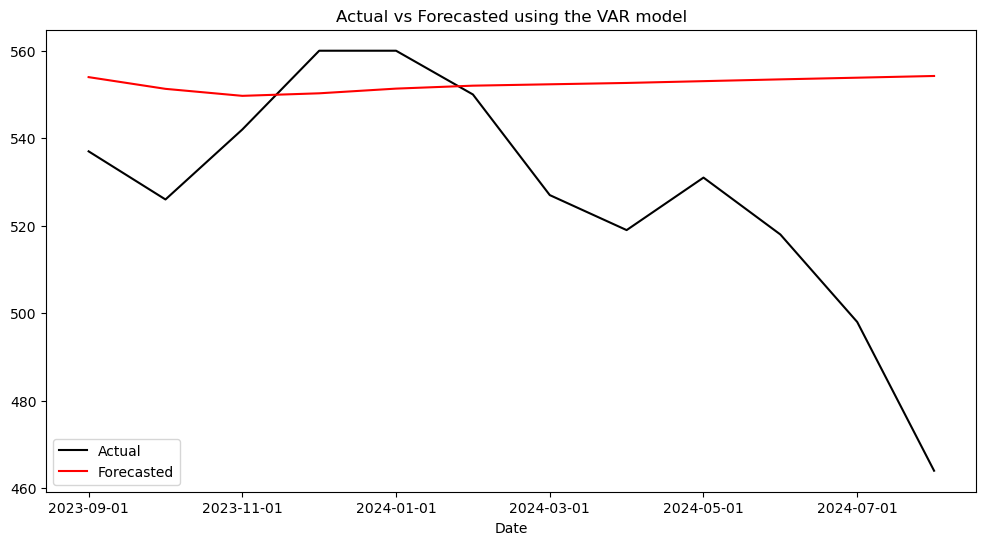

In [327]:
# Compare forecasted with actual results
fig, ax = plt.subplots(figsize=(12, 6))

final_df_test['HRC \n(FOB, $/t)'].plot(color='k', label='Actual')
df_forecast_processed['HRC \n(FOB, $/t)_forecast'].plot(color='r', label='Forecasted')

plt.title('Actual vs Forecasted using the VAR model')
ax.legend()

In [328]:
# Error metrics

forecast = df_forecast_processed['HRC \n(FOB, $/t)_forecast'].values
actual = final_df_test['HRC \n(FOB, $/t)']

mae = np.mean(np.abs(forecast - actual))
rmse = np.mean((forecast - actual)**2)**.5
mape = np.mean(np.abs(forecast - actual)/np.abs(actual))
print('Mean Absolute Error: ', mae)
print('Root Mean Squared Error: ', rmse)
print('Mean Absolute Percentage Error: ', mape)

Mean Absolute Error:  27.7383586780045
Root Mean Squared Error:  36.4393009984218
Mean Absolute Percentage Error:  0.054978186257065055


## VAR Model ver 2
using randomly selected variables, splitting into train & test and using train to do the forecasting instead of whole data set

In [329]:
# Read csv
file_path = '../data/final/wo_na.csv'
df = pd.read_csv(file_path)

In [330]:
df.head()

,Unnamed: 0,Month_Dt,Month,Year,"HRC \n(FOB, $/t)",Domestic Scrap (DDP Jiangsu incl. VAT $/t),RM Cost \n($/t),HRC - RM \nSpread ($/t),CS Production (Mnt),Exports \n(Mnt),...,Monthly Export of semis & finished steel (Mt.),YTD Iron ore Imports (Mt.),YTD Iron ore Production (Mt.),Monthly Iron ore Production (Mt.),Fixed asset investment in real estate development in urban areas (y-o-y )Growth,Automobile Production (y-o-y),Civil Metal-Vessels/Steel Ships (y-o-y),Household Fridges (y-o-y),Air Conditioner (y-o-y),Manufacturing PMI for steel
0,8,2006-09-01,9,2006,472,252,211,261,36.0,5.0,...,5.14,247.20,405.80,56.50,24.3,24.0,6.0,34.2,3.9,51.7
1,9,2006-10-01,10,2006,477,260,185,292,38.0,5.0,...,5.19,297.69,462.30,56.50,24.1,25.1,11.4,31.8,6.7,55.9
2,10,2006-11-01,11,2006,470,262,182,288,38.0,6.0,...,6.11,297.69,521.50,59.20,24.0,26.1,8.3,28.9,7.2,54.9
3,11,2006-12-01,12,2006,470,270,188,282,39.0,6.0,...,6.05,326.30,588.20,66.70,21.8,27.0,13.1,15.8,16.1,50.1
4,12,2007-01-01,1,2007,470,273,197,273,38.0,5.0,...,4.95,133.55,252.28,69.01,24.3,45.0,8.6,15.8,16.1,55.4


### Section to be replaced by feature selection / granger causality test

For the sake of testing the VAR model, I will select a few stationary variables from the ADF test:

1. RM Cost ($/t)
2. HRC - RM Spread ($/t)
3. Export as % of Production

In [331]:
list_of_variables = ['RM Cost \n($/t)', 'HRC - RM \nSpread ($/t)', 'Export as % of Production']
hrc = ['Month_Dt', 'HRC \n(FOB, $/t)']
final_cols = hrc + list_of_variables

df = df[final_cols]
df.head()

,Month_Dt,"HRC \n(FOB, $/t)",RM Cost \n($/t),HRC - RM \nSpread ($/t),Export as % of Production
0,2006-09-01,472,211,261,14.0
1,2006-10-01,477,185,292,14.0
2,2006-11-01,470,182,288,16.0
3,2006-12-01,470,188,282,15.0
4,2007-01-01,470,197,273,13.0


In [332]:
# Set date column as the index
final_df = df.copy()
final_df = final_df.rename(columns={'Month_Dt':'Date'})
final_df.set_index('Date', inplace=True)

final_df.head()

,"HRC \n(FOB, $/t)",RM Cost \n($/t),HRC - RM \nSpread ($/t),Export as % of Production
Date,,,,
2006-09-01,472,211,261,14.0
2006-10-01,477,185,292,14.0
2006-11-01,470,182,288,16.0
2006-12-01,470,188,282,15.0
2007-01-01,470,197,273,13.0


In [333]:
# Split dataset into train and test set
nobs = 12 #setting the number of forecasted periods to 12 months / 1 year
final_df_train, final_df_test = final_df[0:-nobs], final_df[-nobs:]

print(final_df_train.shape)
print(final_df_test.shape)

(204, 4)
(12, 4)


In [334]:
# Determine the best number of lags
model = VAR(final_df_train)
x = model.select_order(maxlags=12)
x.summary()

,AIC,BIC,FPE,HQIC
0,19.31,19.37,2.423e+08,19.33
1,13.84,14.18*,1.027e+06,13.98
2,13.58,14.19,7.882e+05,13.82*
3,13.52,14.40,7.413e+05,13.87
4,13.42*,14.57,6.719e+05*,13.88
5,13.42,14.85,6.786e+05,14.00
6,13.43,15.13,6.860e+05,14.12
7,13.48,15.45,7.241e+05,14.28
8,13.51,15.75,7.441e+05,14.41
9,13.61,16.12,8.263e+05,14.62


In [335]:
# As lag 4 gives the lowest AIC value, to fit it accordingly in the model
model_fitted = model.fit(4)
model_fitted.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Tue, 11, Mar, 2025
Time:                     17:36:16
--------------------------------------------------------------------
No. of Equations:         4.00000    BIC:                    14.6074
Nobs:                     200.000    HQIC:                   13.9398
Log likelihood:          -2415.74    FPE:                    720410.
AIC:                      13.4859    Det(Omega_mle):         519830.
--------------------------------------------------------------------
Results for equation HRC 
(FOB, $/t)
                                  coefficient       std. error           t-stat            prob
-----------------------------------------------------------------------------------------------
const                               48.409201        13.702080            3.533           0.000
L1.HRC 
(FOB, $/t)                   8.498117         4.830025            1.759       

In [336]:
# Test if there is any serial correlation in the residuals using the Durbin Watson's Statistic.
# Significant correlation may imply that some pattern in the time series has yet to be captured and may
# require more variables to be included / using a different lag order / using a different model.
# A Durbin Watson value close to 2 implies no significant serial correlation. Values closer to 0 and 4 imply
# positive and negative serial correlation respectively.

out = durbin_watson(model_fitted.resid)

for col, val in zip(final_df.columns, out):
    print(col, ':', round(val, 2))

HRC 
(FOB, $/t) : 1.95
RM Cost 
($/t) : 2.04
HRC - RM 
Spread ($/t) : 2.05
Export as % of Production : 1.98


In [337]:
# Using the last 4 observations (since lag order is 4) to forecast the following periods
lag_order = model_fitted.k_ar
forecast_input = final_df_train.values[-lag_order:]
forecast_input

array([[561., 399., 163.,   9.],
       [542., 411., 131.,   8.],
       [550., 412., 138.,   8.],
       [553., 430., 124.,  10.]])

In [338]:
# Forecast the following 12 periods (length of test set)
fc = model_fitted.forecast(y=forecast_input, steps=31)
fc_period = pd.date_range(start='9/1/2023', end='3/1/2026', freq='MS')
df_forecast = pd.DataFrame(fc, index=fc_period, columns=final_df_test.columns + '_f')
df_forecast

,"HRC \n(FOB, $/t)_f",RM Cost \n($/t)_f,HRC - RM \nSpread ($/t)_f,Export as % of Production_f
2023-09-01,554.441580,420.866408,133.517514,9.705764
2023-10-01,544.100800,404.260869,139.749810,9.360035
2023-11-01,534.457080,390.243986,144.273361,9.342363
2023-12-01,529.392911,380.044490,149.267655,9.093810
2024-01-01,524.099548,369.976004,154.038938,8.944269
2024-02-01,518.349690,361.615319,156.671351,8.891951
2024-03-01,514.922392,354.578694,160.270738,8.829521
2024-04-01,512.872563,348.904212,163.897509,8.781519
2024-05-01,511.890166,345.023536,166.802653,8.749414
2024-06-01,511.943424,342.145680,169.729536,8.734520


In [339]:
df_forecast1, df_forecast2 = df_forecast[0:-19], df_forecast[-19:]
final_df.index = pd.to_datetime(final_df.index)
final_df_train.index = pd.to_datetime(final_df_train.index)
final_df_test.index = pd.to_datetime(final_df_test.index)

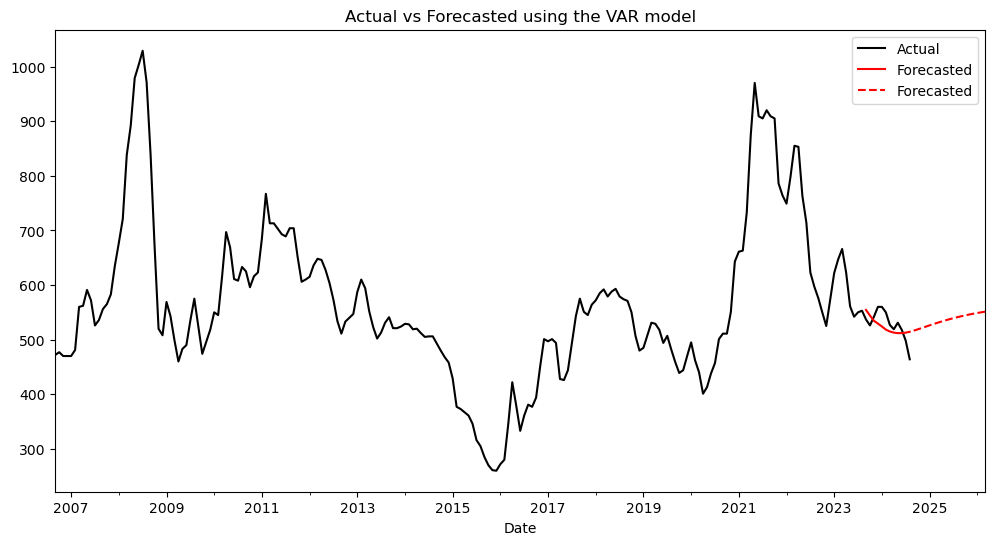

In [340]:
# Compare forecasted with actual results
fig, ax = plt.subplots(figsize=(12, 6))

final_df['HRC \n(FOB, $/t)'].plot(color='k', label='Actual')
df_forecast1['HRC \n(FOB, $/t)_f'].plot(color='r', label='Forecasted')
df_forecast2['HRC \n(FOB, $/t)_f'].plot(color='r', linestyle ='dashed', label='Forecasted')

plt.title('Actual vs Forecasted using the VAR model')
ax.legend()

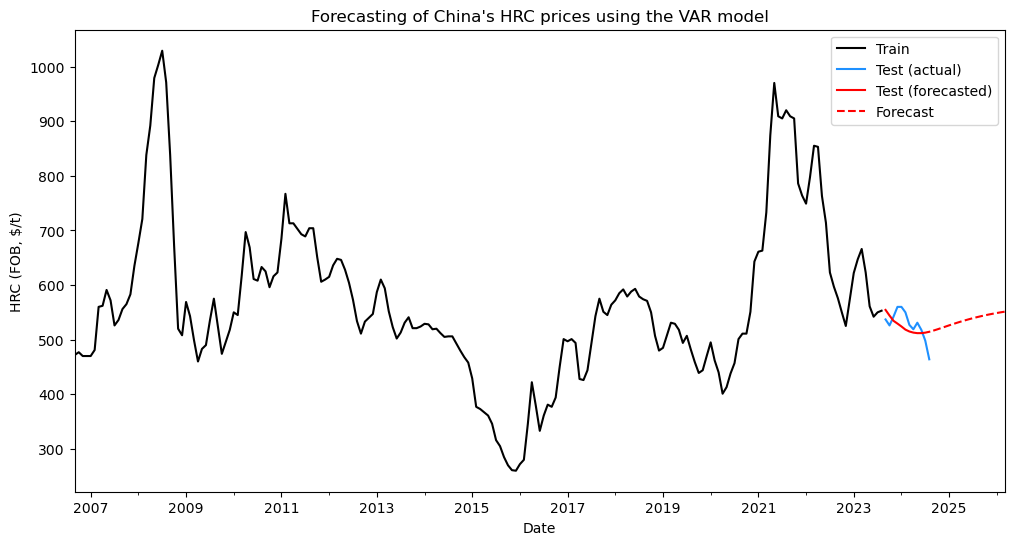

In [341]:
# Compare forecasted with actual results
fig, ax = plt.subplots(figsize=(12, 6))

final_df_train['HRC \n(FOB, $/t)'].plot(color='k', label='Train')
final_df_test['HRC \n(FOB, $/t)'].plot(color='dodgerblue', label='Test (actual)')
df_forecast1['HRC \n(FOB, $/t)_f'].plot(color='r', label='Test (forecasted)')
df_forecast2['HRC \n(FOB, $/t)_f'].plot(color='r', linestyle ='dashed', label='Forecast')

plt.title("Forecasting of China's HRC prices using the VAR model")
plt.ylabel("HRC (FOB, $/t)")
plt.xlabel("Date")
ax.legend()

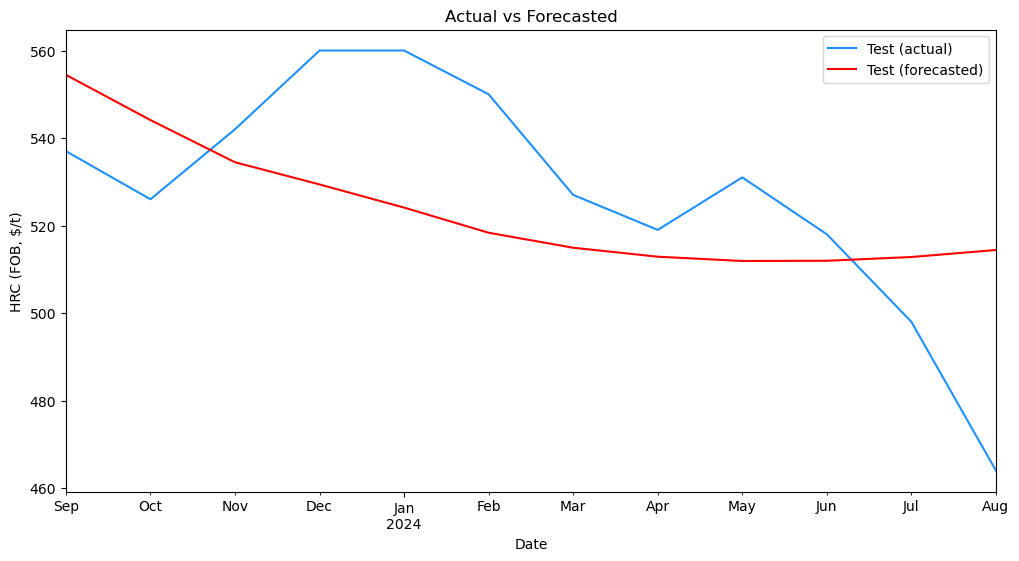

In [342]:
fig, ax = plt.subplots(figsize=(12, 6))

final_df_test['HRC \n(FOB, $/t)'].plot(color='dodgerblue', label='Test (actual)')
df_forecast1['HRC \n(FOB, $/t)_f'].plot(color='r', label='Test (forecasted)')

plt.title("Actual vs Forecasted")
plt.ylabel("HRC (FOB, $/t)")
plt.xlabel("Date")
ax.legend()

In [343]:
# Error metrics

forecast = df_forecast1['HRC \n(FOB, $/t)_f'].values
actual = final_df_test['HRC \n(FOB, $/t)']

mae = np.mean(np.abs(forecast - actual))
rmse = np.mean((forecast - actual)**2)**.5
mape = np.mean(np.abs(forecast - actual)/np.abs(actual))
print('Mean Absolute Error: ', mae)
print('Root Mean Squared Error: ', rmse)
print('Mean Absolute Percentage Error: ', mape)

Mean Absolute Error:  20.81854274214851
Root Mean Squared Error:  24.59861818786813
Mean Absolute Percentage Error:  0.039823221204116244


### Conclusion
As seen from the graph, the VAR model captured the decreasing trend of the HRC prices. Also, given the relatively low error scores, we can conclude that the VAR model performed decently in forecasting China's HRC export prices.

### Impulse Response Analysis

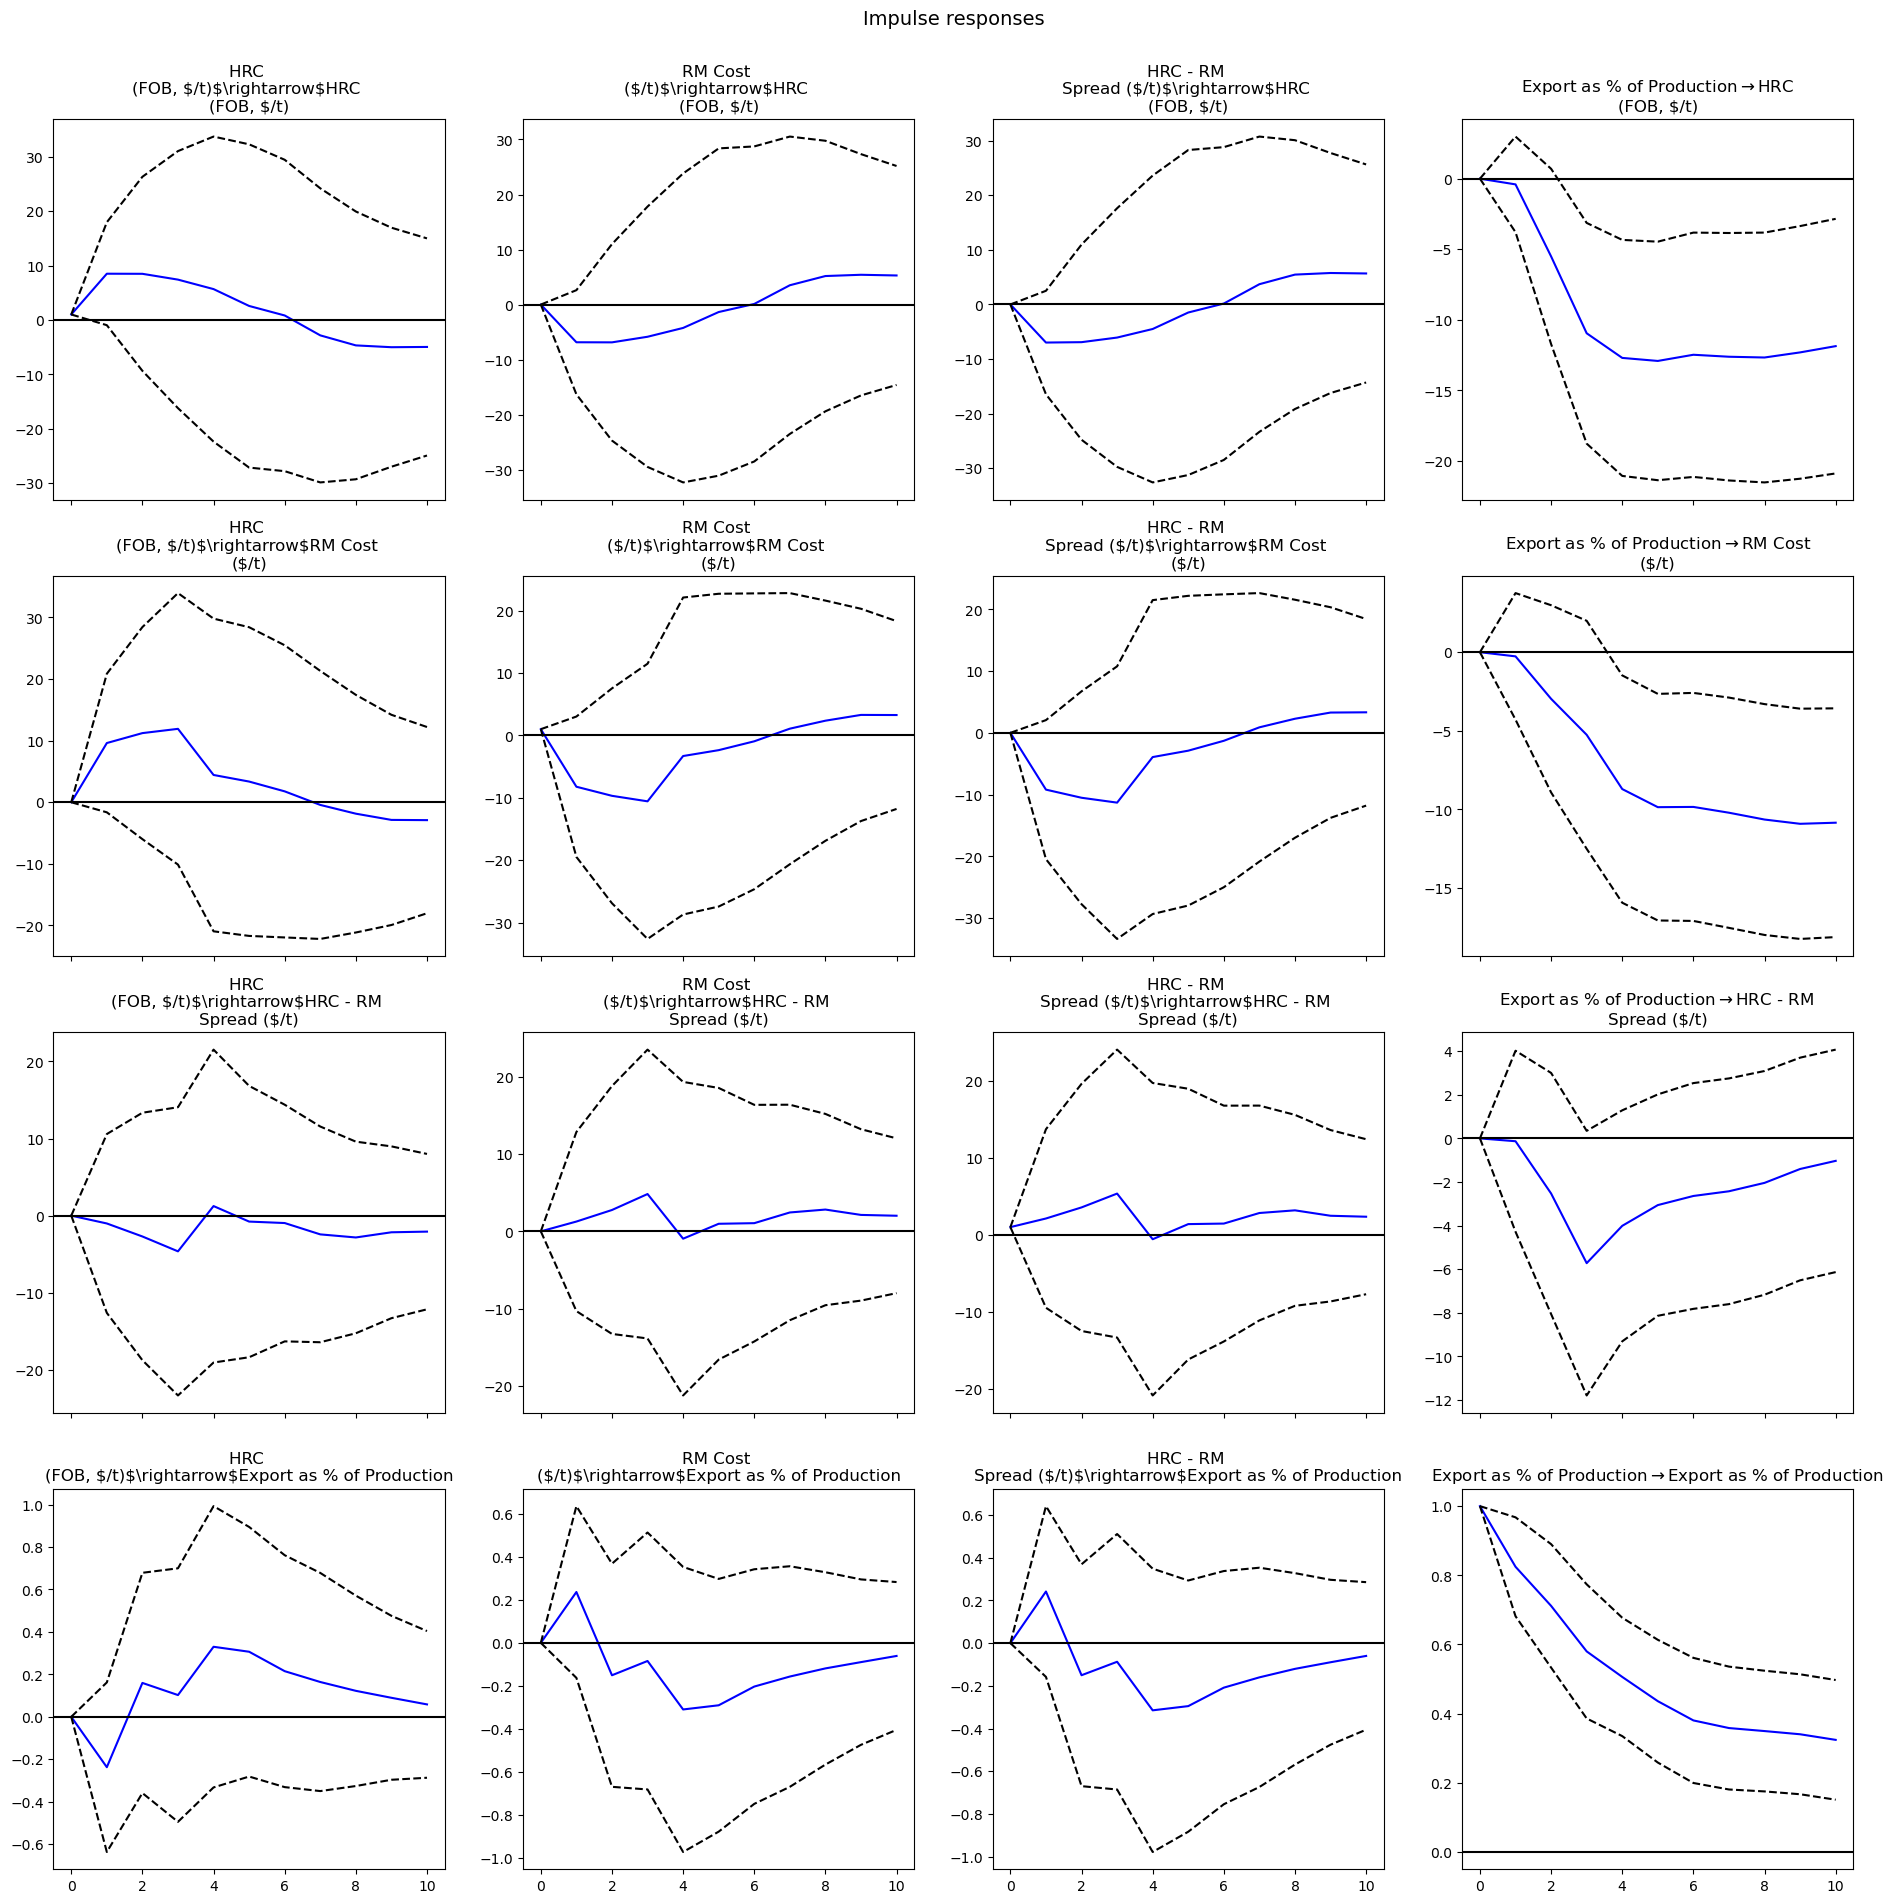

In [344]:
irf = model_fitted.irf(10)
#irf.plot(impulse='RM Cost \n($/t)', response='HRC \n(FOB, $/t)', figsize=(12,6))
irf.plot(figsize=(20,20))
plt.show()

## VAR Model ver 3
using randomly selected variables, using whole data set as train data set to predict the prices

In [345]:
# Read csv
file_path = '../data/final/wo_na.csv'
df = pd.read_csv(file_path)
df.head()

,Unnamed: 0,Month_Dt,Month,Year,"HRC \n(FOB, $/t)",Domestic Scrap (DDP Jiangsu incl. VAT $/t),RM Cost \n($/t),HRC - RM \nSpread ($/t),CS Production (Mnt),Exports \n(Mnt),...,Monthly Export of semis & finished steel (Mt.),YTD Iron ore Imports (Mt.),YTD Iron ore Production (Mt.),Monthly Iron ore Production (Mt.),Fixed asset investment in real estate development in urban areas (y-o-y )Growth,Automobile Production (y-o-y),Civil Metal-Vessels/Steel Ships (y-o-y),Household Fridges (y-o-y),Air Conditioner (y-o-y),Manufacturing PMI for steel
0,8,2006-09-01,9,2006,472,252,211,261,36.0,5.0,...,5.14,247.20,405.80,56.50,24.3,24.0,6.0,34.2,3.9,51.7
1,9,2006-10-01,10,2006,477,260,185,292,38.0,5.0,...,5.19,297.69,462.30,56.50,24.1,25.1,11.4,31.8,6.7,55.9
2,10,2006-11-01,11,2006,470,262,182,288,38.0,6.0,...,6.11,297.69,521.50,59.20,24.0,26.1,8.3,28.9,7.2,54.9
3,11,2006-12-01,12,2006,470,270,188,282,39.0,6.0,...,6.05,326.30,588.20,66.70,21.8,27.0,13.1,15.8,16.1,50.1
4,12,2007-01-01,1,2007,470,273,197,273,38.0,5.0,...,4.95,133.55,252.28,69.01,24.3,45.0,8.6,15.8,16.1,55.4


### Section to be replaced by feature selection / granger causality test

For the sake of testing the VAR model, I will select a few stationary variables from the ADF test:

1. RM Cost ($/t)
2. HRC - RM Spread ($/t)
3. Export as % of Production

In [346]:
list_of_variables = ['RM Cost \n($/t)', 'HRC - RM \nSpread ($/t)', 'Export as % of Production']
hrc = ['Month_Dt', 'HRC \n(FOB, $/t)']
final_cols = hrc + list_of_variables

df = df[final_cols]
df.head()

,Month_Dt,"HRC \n(FOB, $/t)",RM Cost \n($/t),HRC - RM \nSpread ($/t),Export as % of Production
0,2006-09-01,472,211,261,14.0
1,2006-10-01,477,185,292,14.0
2,2006-11-01,470,182,288,16.0
3,2006-12-01,470,188,282,15.0
4,2007-01-01,470,197,273,13.0


In [347]:
df.tail()

,Month_Dt,"HRC \n(FOB, $/t)",RM Cost \n($/t),HRC - RM \nSpread ($/t),Export as % of Production
211,2024-04-01,519,416,103,11.0
212,2024-05-01,531,427,104,10.0
213,2024-06-01,518,420,98,10.0
214,2024-07-01,498,407,92,9.0
215,2024-08-01,464,363,100,12.0


In [348]:
# Set date column as the index
final_df = df.copy()
final_df = final_df.rename(columns={'Month_Dt':'Date'})
final_df.set_index('Date', inplace=True)

final_df.head()

,"HRC \n(FOB, $/t)",RM Cost \n($/t),HRC - RM \nSpread ($/t),Export as % of Production
Date,,,,
2006-09-01,472,211,261,14.0
2006-10-01,477,185,292,14.0
2006-11-01,470,182,288,16.0
2006-12-01,470,188,282,15.0
2007-01-01,470,197,273,13.0


In [349]:
# Determine the best number of lags
model = VAR(final_df)
x = model.select_order(maxlags=12)
x.summary()

,AIC,BIC,FPE,HQIC
0,19.43,19.49,2.742e+08,19.46
1,13.83,14.15,1.010e+06,13.96
2,13.54,14.13*,7.607e+05,13.78*
3,13.48,14.33,7.152e+05,13.82
4,13.39*,14.49,6.532e+05*,13.84
5,13.40,14.77,6.619e+05,13.95
6,13.42,15.05,6.778e+05,14.08
7,13.45,15.34,7.000e+05,14.21
8,13.47,15.62,7.149e+05,14.34
9,13.55,15.96,7.809e+05,14.53


In [350]:
# As lag 4 gives the lowest AIC value, to fit it accordingly in the model
model_fitted = model.fit(4)
model_fitted.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Tue, 11, Mar, 2025
Time:                     17:36:19
--------------------------------------------------------------------
No. of Equations:         4.00000    BIC:                    14.5303
Nobs:                     212.000    HQIC:                   13.8888
Log likelihood:          -2561.35    FPE:                    697342.
AIC:                      13.4537    Det(Omega_mle):         512209.
--------------------------------------------------------------------
Results for equation HRC 
(FOB, $/t)
                                  coefficient       std. error           t-stat            prob
-----------------------------------------------------------------------------------------------
const                               48.685358        13.365310            3.643           0.000
L1.HRC 
(FOB, $/t)                   8.778160         4.471712            1.963       

In [351]:
# Test if there is any serial correlation in the residuals using the Durbin Watson's Statistic.
# Significant correlation may imply that some pattern in the time series has yet to be captured and may
# require more variables to be included / using a different lag order / using a different model.
# A Durbin Watson value close to 2 implies no significant serial correlation. Values closer to 0 and 4 imply
# positive and negative serial correlation respectively.

out = durbin_watson(model_fitted.resid)

for col, val in zip(final_df.columns, out):
    print(col, ':', round(val, 2))

HRC 
(FOB, $/t) : 1.95
RM Cost 
($/t) : 2.04
HRC - RM 
Spread ($/t) : 2.06
Export as % of Production : 1.98


In [352]:
# Using the last 4 observations (since lag order is 4) to forecast the following periods
lag_order = model_fitted.k_ar
forecast_input = final_df.values[-lag_order:]
forecast_input

array([[531., 427., 104.,  10.],
       [518., 420.,  98.,  10.],
       [498., 407.,  92.,   9.],
       [464., 363., 100.,  12.]])

In [353]:
# Forecast the following 12 periods (length of test set)
fc = model_fitted.forecast(y=forecast_input, steps=19)
fc_period = pd.date_range(start='9/1/2024', end='3/1/2026', freq='MS')
df_forecast = pd.DataFrame(fc, index=fc_period, columns=final_df.columns + '_f')
df_forecast

,"HRC \n(FOB, $/t)_f",RM Cost \n($/t)_f,HRC - RM \nSpread ($/t)_f,Export as % of Production_f
2024-09-01,457.626225,351.691174,105.931233,10.754707
2024-10-01,448.257308,335.217955,113.221409,10.669914
2024-11-01,432.581690,333.748493,98.588759,9.962043
2024-12-01,429.562444,314.351580,115.069513,9.974246
2025-01-01,430.210335,305.611161,124.544074,10.008744
2025-02-01,437.338002,304.757745,132.497056,9.920661
2025-03-01,440.381250,301.810217,138.441598,9.920172
2025-04-01,442.179468,299.160536,142.911591,9.982873
2025-05-01,446.314665,296.434798,149.773869,10.053322
2025-06-01,451.208105,295.737109,155.368203,10.066582


In [354]:
df_forecast.index = pd.to_datetime(df_forecast.index)
final_df.index = pd.to_datetime(final_df.index)
print(df_forecast.index.dtype)
print(final_df.index.dtype)

datetime64[ns]
datetime64[ns]


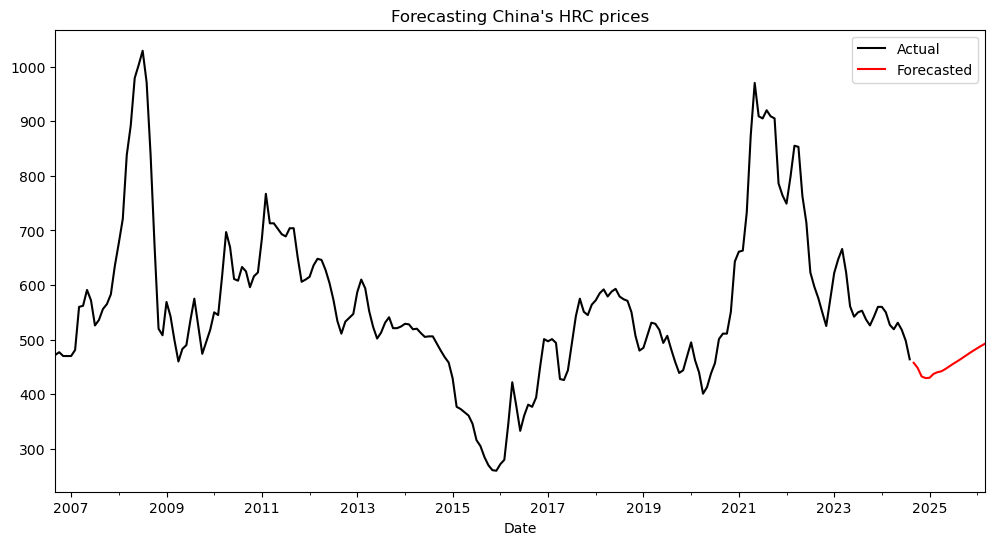

In [355]:
# Compare forecasted with actual results
fig, ax = plt.subplots(figsize=(12, 6))

final_df['HRC \n(FOB, $/t)'].plot(color='k', label='Actual')
df_forecast['HRC \n(FOB, $/t)_f'].plot(color='r', label='Forecasted')

plt.title("Forecasting China's HRC prices")
ax.legend()

In [356]:
'''
## VAR Model ver 2
# Read csv
file_path = '../data/final/wo_na.csv'
df = pd.read_csv(file_path)
df.head()
### Section to be replaced by feature selection / granger causality test

For the sake of testing the VAR model, I will select a few stationary variables from the ADF test:

1. RM Cost ($/t)
2. HRC - RM Spread ($/t)
3. Export as % of Production
list_of_variables = ['RM Cost \n($/t)', 'HRC - RM \nSpread ($/t)', 'Export as % of Production']
hrc = ['Month_Dt', 'HRC \n(FOB, $/t)']
final_cols = hrc + list_of_variables

df = df[final_cols]
df.head()
# Set date column as the index
final_df = df.copy()
final_df = final_df.rename(columns={'Month_Dt':'Date'})
final_df.set_index('Date', inplace=True)

final_df.head()
# Split dataset into train and test set
nobs = 12 #setting the number of forecasted periods to 12 months / 1 year
final_df_train, final_df_test = final_df[0:-nobs], final_df[-nobs:]

print(final_df_train.shape)
print(final_df_test.shape)
# Determine the best number of lags
model = VAR(final_df_train)
x = model.select_order(maxlags=12)
x.summary()
# As lag 4 gives the lowest AIC value, to fit it accordingly in the model
model_fitted = model.fit(4)
model_fitted.summary()
# Test if there is any serial correlation in the residuals using the Durbin Watson's Statistic.
# Significant correlation may imply that some pattern in the time series has yet to be captured and may
# require more variables to be included / using a different lag order / using a different model.
# A Durbin Watson value close to 2 implies no significant serial correlation. Values closer to 0 and 4 imply
# positive and negative serial correlation respectively.

out = durbin_watson(model_fitted.resid)

for col, val in zip(final_df.columns, out):
    print(col, ':', round(val, 2))
# Using the last 4 observations (since lag order is 4) to forecast the following periods
lag_order = model_fitted.k_ar
forecast_input = final_df_train.values[-lag_order:]
forecast_input
# Forecast the following 12 periods (length of test set)
fc = model_fitted.forecast(y=forecast_input, steps=nobs)
df_forecast = pd.DataFrame(fc, index=final_df_test.index, columns=final_df_test.columns + '_f')
df_forecast
# Compare forecasted with actual results
fig, ax = plt.subplots(figsize=(12, 6))

final_df_test['HRC \n(FOB, $/t)'].plot(color='k', label='Actual')
df_forecast['HRC \n(FOB, $/t)_f'].plot(color='r', label='Forecasted')

plt.title('Actual vs Forecasted using the VAR model')
ax.legend()
# Error metrics

forecast = df_forecast['HRC \n(FOB, $/t)_f'].values
actual = final_df_test['HRC \n(FOB, $/t)']

mae = np.mean(np.abs(forecast - actual))
rmse = np.mean((forecast - actual)**2)**.5
mape = np.mean(np.abs(forecast - actual)/np.abs(actual))
print('Mean Absolute Error: ', mae)
print('Root Mean Squared Error: ', rmse)
print('Mean Absolute Percentage Error: ', mape)
### Conclusion
As seen from the graph, the VAR model captured the decreasing trend of the HRC prices. Also, given the relatively low error scores, we can conclude that the VAR model performed decently in forecasting China's HRC export prices.
### Impulse Response Analysis
irf = model_fitted.irf(10)
#irf.plot(impulse='RM Cost \n($/t)', response='HRC \n(FOB, $/t)', figsize=(12,6))
irf.plot(figsize=(20,20))
plt.show()
'''

"\n## VAR Model ver 2\n# Read csv\nfile_path = '../data/final/wo_na.csv'\ndf = pd.read_csv(file_path)\ndf.head()\n### Section to be replaced by feature selection / granger causality test\n\nFor the sake of testing the VAR model, I will select a few stationary variables from the ADF test:\n\n1. RM Cost ($/t)\n2. HRC - RM Spread ($/t)\n3. Export as % of Production\nlist_of_variables = ['RM Cost \n($/t)', 'HRC - RM \nSpread ($/t)', 'Export as % of Production']\nhrc = ['Month_Dt', 'HRC \n(FOB, $/t)']\nfinal_cols = hrc + list_of_variables\n\ndf = df[final_cols]\ndf.head()\n# Set date column as the index\nfinal_df = df.copy()\nfinal_df = final_df.rename(columns={'Month_Dt':'Date'})\nfinal_df.set_index('Date', inplace=True)\n\nfinal_df.head()\n# Split dataset into train and test set\nnobs = 12 #setting the number of forecasted periods to 12 months / 1 year\nfinal_df_train, final_df_test = final_df[0:-nobs], final_df[-nobs:]\n\nprint(final_df_train.shape)\nprint(final_df_test.shape)\n# Determi